# Clean-up raw job logs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')
from tools import read_request_logs

## Read the raw job logs

In [3]:
job_logs_raw = read_request_logs('../request_logs/', '*.tar.gz')

Reading the original logs takes a lot of time, so we use help ourselves with a (temporary) much faster disk storage format...

In [4]:
job_logs_raw.to_parquet('job_logs_raw.parquet', index=False, compression='gzip')

In [5]:
job_logs_raw = pd.read_parquet('job_logs_raw.parquet')

In [6]:
job_logs_raw

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Identifier,Time,Filename
0,clbigmem,0,RUN,-,45.40,10000.86,560223.0,Y,Y,Y,1.0,50f38293dabf53e9,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
1,clbigmem,0,RUN,-,66.43,1461501.36,181504.0,Y,Y,Y,1.0,1cadd9af115874fc,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
2,clbigmem,0,RUN,-,44.20,2973694.55,93235.0,Y,Y,Y,1.0,84b513a49a615a33,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
3,clbigmem,0,RUN,-,2.01,1166604.28,36574.0,Y,Y,Y,3.0,817f139219e72642,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
4,clbigmem,0,RUN,-,30.28,138055.86,4353.0,Y,Y,Y,1.0,fc3ffa2fca1e77be,2020-02-06 19:53:11+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025942,vequeue,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,13428e1c0b04b6ac,2020-04-07 09:54:04+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
3025943,clmedium,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,d265ff487b48e5fc,2020-04-07 09:54:04+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
3025944,clmedium,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,308f7cb964beb126,2020-04-07 09:54:04+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
3025945,clmedium,0,RUN,-,NaN,NaN,NaN,Y,Y,Y,1.0,0b37050713eca404,2020-04-07 09:54:04+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz


## Information content assessment
We go through each of the columns in the above Pandas dataframe and check which rows/columns contain valuable information that need to be kept for the analysis in the follow-up Jupyter notebooks. Everything else will be dropped.

In [7]:
def job_prevalence(logs, parameter):
    grouped = logs.groupby(parameter)
    total_job_number = logs['Time'].count()
    print(grouped[parameter].count()/total_job_number*100)

### Batch class
The majority of job entries (about 95.1%) is located on the Linux cluster, i.e. in the `cl*` and the `feque` batch classes. We will limit the analysis to this heavily occupied part of the system and will drop job entries for the vector host `ve*` part (about 4.7%) and those for the interactive `clintera` and experimental `cltestqu` batch classes (about 0.2%).

In [8]:
job_prevalence(job_logs_raw, 'Queue')

Queue
clbigmem     2.069501
clexpres     0.799419
clfo2        5.431391
clintera     0.166031
cllong      24.965044
clmedium    59.529033
cltestqu     0.040483
feque        2.339268
veexpres     1.098334
veintera     0.039525
vequeue      3.521972
Name: Queue, dtype: float64


In [9]:
100*job_logs_raw['Queue'].str.contains('clbigmem|cllong|clmedium|clexpres|feque|clfo2').sum()/job_logs_raw['Time'].count()

95.13365567870157

In [10]:
100*job_logs_raw['Queue'].str.contains('veexpres|veintera|vequeue').sum()/job_logs_raw['Time'].count()

4.659830459687496

In [11]:
100*job_logs_raw['Queue'].str.contains('clintera|cltestqu').sum()/job_logs_raw['Time'].count()

0.20651386161092708

### Job priority
Apparently, all jobs entries have the same priority. There are no valuable information here, the `Pri` column will thus be dropped.

In [12]:
job_prevalence(job_logs_raw, 'Pri')

Pri
0    100.0
Name: Pri, dtype: float64


### Job status
The majority of the job entries (about 99.7%) is either in a queued or running state. We keep the job status information, as these are important for the estimation of job characteristics later on.

In [13]:
job_prevalence(job_logs_raw, 'STT')

STT
EXT     0.060180
HLD     0.096829
POR     0.012955
PRR     0.029214
QUE    53.990205
RUN    45.701825
STG     0.010079
WAT     0.098713
Name: STT, dtype: float64


In [14]:
100*job_logs_raw['STT'].str.contains('QUE|RUN').sum()/job_logs_raw['Time'].count()

99.6920302966311

job request states as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC

```
ARI arriving
CHK checkpointing
EXT exiting
FWD forwarding
GQD global_queued
HLD held
HOL holding
MIG migrating
POR post-running
PRR pre-running
QUE queued
RST restarting
RUN running
SUS suspending, suspended, resuming
STG staging
TRS transferring
WAT waiting
```

### Stall status
Jobs that are stalled (about 0.006% of the job entries and 0.002% of the individual jobs) will be dropped as they are elapsing w/o using CPU and memory resources. They are very few and not much will be learned during a follow-up analysis.

In [15]:
job_prevalence(job_logs_raw, 'S')

S
-    99.994316
Y     0.005684
Name: S, dtype: float64


In [16]:
these_identifiers = job_logs_raw[job_logs_raw['S']=='Y']['Identifier'].unique()
100*these_identifiers.size/job_logs_raw['Identifier'].unique().size

0.002476596166229135

stall states as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC

```
Stall Status (S)
Y Stall
Normal
```

In [17]:
these_jobs = job_logs_raw.set_index("Identifier")['S'].str.contains('Y')
job_logs_raw.set_index("Identifier").loc[these_jobs]

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,68145.0,Y,Y,Y,NaN,2020-02-18 20:36:55+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,68750.0,Y,Y,Y,NaN,2020-02-18 20:47:00+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,69355.0,Y,Y,Y,NaN,2020-02-18 20:57:06+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,69959.0,Y,Y,Y,NaN,2020-02-18 21:07:09+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,70564.0,Y,Y,Y,NaN,2020-02-18 21:17:14+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,170975.0,Y,Y,Y,NaN,2020-02-20 01:10:45+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,171582.0,Y,Y,Y,NaN,2020-02-20 01:20:53+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
af04ba2641814a0e,clmedium,0,RUN,Y,0.0,0.0,172189.0,Y,Y,Y,NaN,2020-02-20 01:31:00+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz


### Scheduler options
The job re-execution, the job hold and the job migration scheduler options are set to `yes` for the majority of job entries. A closer investigation reveals that only jobs in the interactive batch classes `clintera` and `veintera` are marked with a `no` for this option. As these batch classes will be dropped anyway, the scheduler options column will be dropped too.

In [18]:
job_prevalence(job_logs_raw, 'R')

R
N     0.205555
Y    99.794445
Name: R, dtype: float64


as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC

```
Re-execution Possible/Not Possible (R)
Y Request with re-execution option
N Request without re-execution option
```

In [19]:
job_prevalence(job_logs_raw, 'H')

H
N     0.205555
Y    99.794445
Name: H, dtype: float64


as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC

```
Hold Possible/Not Possible (H)
Y Request with hold option
N Request without hold option
```

In [20]:
job_prevalence(job_logs_raw, 'M')

M
N     0.205555
Y    99.794445
Name: M, dtype: float64


as documented in the [NQSV User's Guide Reference](https://www.hpc.nec/documents/index.en.xhtml#idm140221910547704) available at NEC

```
Job Migration Possible/Not Possible (M)
Y Request with Job Migration option
N Request without Job Migration option
```

In [21]:
these_jobs = job_logs_raw.set_index("Identifier")['R'].str.contains('N')
job_logs_raw.set_index("Identifier").loc[these_jobs]

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
fc6df54fe54dd521,veintera,0,RUN,-,0.01611,0.05,393.0,N,N,N,1.0,2020-02-10 11:00:51+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
fc6df54fe54dd521,veintera,0,RUN,-,0.15359,80.41,1015.0,N,N,N,1.0,2020-02-10 11:11:13+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
fc6df54fe54dd521,veintera,0,RUN,-,0.15361,56.62,1643.0,N,N,N,1.0,2020-02-10 11:21:42+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
fc6df54fe54dd521,veintera,0,RUN,-,0.02354,3.85,2266.0,N,N,N,1.0,2020-02-10 11:32:04+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
fc6df54fe54dd521,veintera,0,RUN,-,0.02308,0.40,2886.0,N,N,N,1.0,2020-02-10 11:42:24+01:00,../request_logs/cycle_2020-02-06-19-52-28.tar.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0c4a1ebb35736842,veintera,0,RUN,-,0.19949,567.80,2135.0,N,N,N,1.0,2020-04-03 17:24:12+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
c8ab9ba87607dddc,clintera,0,RUN,-,2.65000,196.84,2525.0,N,N,N,1.0,2020-04-03 17:24:12+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
0c4a1ebb35736842,veintera,0,RUN,-,0.19950,732.35,2744.0,N,N,N,1.0,2020-04-03 17:34:22+02:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz


In [22]:
for column in ['R', 'H', 'M']:
    print(column, job_logs_raw.set_index(column).loc['N']['Queue'].unique())

R ['veintera' 'clintera']
H ['veintera' 'clintera']
M ['veintera' 'clintera']


### Jobs per job request
For full node requests this can be interpreted as total node number. This is valuable information and is thus kept.

In [23]:
job_prevalence(job_logs_raw, 'Jobs')

Jobs
1.0     84.648806
2.0      1.903074
3.0      1.676302
4.0     10.289638
5.0      0.071118
6.0      0.089625
7.0      0.037839
8.0      1.016806
10.0     0.063914
16.0     0.155852
29.0     0.000033
30.0     0.003173
32.0     0.037608
64.0     0.000529
Name: Jobs, dtype: float64


## Data integrity assessments
There could be more of these...

### Job logging time step and job identifier uniqueness
The logging time step should be close to about ten minutes, which is the value set in the logging script. The way in which this analysis is implemented (grouping the job log entries by identifier and calculating time deltas separately for each identifier, which is actually not very straight ahead) is also a quick check for job identifier uniqueness (note that only a cropped hash is written to disk by the logging script). We find, that the logging time step is mostly 10-11 minutes, and that no multiple job identifiers occur. Thus no manual clean-ups are necessary.

In [24]:
delta_timestamp = job_logs_raw.groupby("Identifier")["Time"].apply(lambda subgroup: subgroup.diff().max())

In [25]:
delta_timestamp = delta_timestamp.sort_values(ascending=False)

In [26]:
delta_timestamp.min(), delta_timestamp.max()

(Timedelta('0 days 00:10:00'), Timedelta('0 days 00:15:51'))

Text(0.5, 0, 'Logging period in minutes')

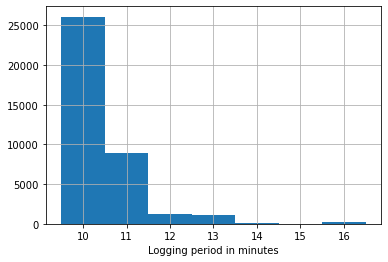

In [27]:
(delta_timestamp.astype('timedelta64[s]')/60).hist(bins=np.arange(9.5,17.5,1))
plt.xlabel('Logging period in minutes')

### Number of batch classes per job

We would expect that each job is assigned to exactly one batch class. However, there are a few jobs (about 0.01%) that were moved manually into another batch class after long waiting times... this might be interesting and we keep these jobs for now.

In [28]:
queues_per_identifier = job_logs_raw.groupby("Identifier")["Queue"].nunique()
100*(queues_per_identifier>1).sum()/queues_per_identifier.size

0.012382980831145673

In [29]:
these_identifiers = queues_per_identifier.index[queues_per_identifier > 1]

In [30]:
job_logs_raw.set_index("Identifier").loc[these_identifiers[3]].sort_values("Time")

,Queue,Pri,STT,S,Memory,CPU,Elapse,R,H,M,Jobs,Time,Filename
Identifier,,,,,,,,,,,,,
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 09:53:59+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:04:10+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:14:17+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:24:23+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:34:24+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:44:25+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 10:54:26+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 11:04:27+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz
747b77c303d99668,clmedium,0,QUE,-,0.00,0.00,0.0,Y,Y,Y,1.0,2020-03-24 11:14:32+01:00,../request_logs/cycle_2020-03-03-11-32-54.tar.gz


## Clean-up raw dataframe now
And show what fraction of the original job entries remains after each single operation.

In [31]:
original_job_log_length = len(job_logs_raw)

### Keep only Linux cluster jobs

In [32]:
job_logs_raw['Queue'].unique()

array(['clbigmem', 'clfo2', 'cllong', 'clmedium', 'veexpres', 'vequeue',
       'clexpres', 'feque', 'veintera', 'clintera', 'cltestqu'],
      dtype=object)

In [33]:
keep_these_batch_classes = 'clbigmem|cllong|clmedium|clexpres|feque|clfo2'
keep_these_jobs = job_logs_raw.set_index("Identifier")['Queue'].str.contains(keep_these_batch_classes)

In [34]:
job_logs_raw = job_logs_raw.set_index('Identifier').loc[keep_these_jobs]
job_logs_raw = job_logs_raw.reset_index()

In [35]:
100*len(job_logs_raw)/original_job_log_length

95.13365567870157

### Drop the stalled jobs

In [36]:
drop_these = job_logs_raw.set_index('S').loc['Y']['Identifier'].unique()

In [37]:
job_logs_raw = job_logs_raw.set_index("Identifier").drop(index=drop_these).reset_index()

In [38]:
100*len(job_logs_raw)/original_job_log_length

95.11703278345588

### Drop incompletely sampled jobs
As que and run times, as well as CPU and memory resources cannot be accurately estimated for those jobs that already existed at the beginning and still exist at the termination of a log cycle. This operation reduces the total job number close to the beginning and end of a log cycle, which should be kept in mind especially for time series analyses later on. We will thus keep the log cycle information for each entry.

In [39]:
drop_these = job_logs_raw.set_index("Time").loc[
    job_logs_raw.groupby(['Filename'])["Time"].min().to_list()
]["Identifier"].to_list()

In [40]:
drop_these = drop_these + job_logs_raw.set_index("Time").loc[
    job_logs_raw.groupby(['Filename'])["Time"].max().to_list()
]["Identifier"].to_list()

In [41]:
job_logs_raw = job_logs_raw.set_index("Identifier").drop(index=drop_these).reset_index()

In [42]:
100*len(job_logs_raw)/original_job_log_length

86.76820843193883

### Convert log cycle information
This information should be kept, see above.

In [44]:
job_logs_raw['Cycle'] = pd.to_datetime('2020-01-01').tz_localize(tz='Europe/Berlin')

for filename in job_logs_raw['Filename'].unique():
    job_logs_raw['Cycle'].mask(
        job_logs_raw['Filename'].str.contains(filename),
        pd.to_datetime(filename.split('_')[-1].split('.')[0],
           format='%Y-%m-%d-%H-%M-%S').tz_localize(tz='Europe/Berlin'),
        inplace=True
    )

In [45]:
job_logs_raw.drop(columns=['Filename'], inplace=True)

### Finally drop also the obsolete columns

In [46]:
job_logs_raw.drop(columns=['Pri', 'S', 'R', 'H', 'M'], inplace=True)

## Store logs on disk

In [47]:
job_logs_raw.to_parquet('job_logs.parquet', index=False, compression='gzip')

In [48]:
job_logs_raw

,Identifier,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
0,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:03:48+01:00,2020-02-06 19:52:28+01:00
1,8e2c3d09f0a6aecf,clmedium,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:03:48+01:00,2020-02-06 19:52:28+01:00
2,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:14:26+01:00,2020-02-06 19:52:28+01:00
3,8e2c3d09f0a6aecf,clmedium,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:14:26+01:00,2020-02-06 19:52:28+01:00
4,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:25:09+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...,...
2625555,45a83906266a2060,clmedium,RUN,14.74,4975041.87,158313.0,1.0,2020-04-07 08:33:51+02:00,2020-03-03 11:32:54+01:00
2625556,45a83906266a2060,clmedium,RUN,14.74,4993981.81,158914.0,1.0,2020-04-07 08:43:52+02:00,2020-03-03 11:32:54+01:00
2625557,45a83906266a2060,clmedium,RUN,14.74,5012918.26,159515.0,1.0,2020-04-07 08:53:53+02:00,2020-03-03 11:32:54+01:00
2625558,45a83906266a2060,clmedium,RUN,14.74,5031856.53,160115.0,1.0,2020-04-07 09:03:54+02:00,2020-03-03 11:32:54+01:00


In [49]:
loaded_job_logs = pd.read_parquet('job_logs.parquet')

In [50]:
loaded_job_logs

,Identifier,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
0,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:03:48+01:00,2020-02-06 19:52:28+01:00
1,8e2c3d09f0a6aecf,clmedium,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:03:48+01:00,2020-02-06 19:52:28+01:00
2,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:14:26+01:00,2020-02-06 19:52:28+01:00
3,8e2c3d09f0a6aecf,clmedium,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:14:26+01:00,2020-02-06 19:52:28+01:00
4,3fe9afee11b2eb7a,cllong,QUE,0.00,0.00,0.0,1.0,2020-02-06 20:25:09+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...,...
2625555,45a83906266a2060,clmedium,RUN,14.74,4975041.87,158313.0,1.0,2020-04-07 08:33:51+02:00,2020-03-03 11:32:54+01:00
2625556,45a83906266a2060,clmedium,RUN,14.74,4993981.81,158914.0,1.0,2020-04-07 08:43:52+02:00,2020-03-03 11:32:54+01:00
2625557,45a83906266a2060,clmedium,RUN,14.74,5012918.26,159515.0,1.0,2020-04-07 08:53:53+02:00,2020-03-03 11:32:54+01:00
2625558,45a83906266a2060,clmedium,RUN,14.74,5031856.53,160115.0,1.0,2020-04-07 09:03:54+02:00,2020-03-03 11:32:54+01:00


## Appendix

In [51]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.4.5.1-hecc5488_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.34-h53a641e_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-7.3.0-hdf63c60_5.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.2.0-hdf63c60_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/llvm-openmp-10.0.0-hc9558a2_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_openmp_mutex-4.5-1_llvm.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.2.0-h24d8f2e_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/abseil-cpp-20200225.2-he1b5a44_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/brotli-1.0.7-he1b5a44_1001.tar.bz2